Crypto Momentum Trading
=======================

Inspiration: Huang et.al: Cryptocurrency Volume-Weighted Time Series Momentum
Data: Polarity Digital

**Notes**

* short term reversal (buying the worst 1d momentum works), fading the best also works but is worse

**Todo**

* overall correlation pre, past 2019
* correlation of momentum and return in different market regimes (above, below sma)

Data Preparation
----------------

In [36]:
# prepare data and compute metrics

import duckdb
from glob import glob
import re
from os.path import basename
import polars as pl
import itertools as it

con = duckdb.connect(database=':memory:')

con.sql('''
    create or replace table coins as
    with stables as (
        select unnest(['dai','bsc-usd','busd','eurc','c1usd','susds','usd1','bfusd','fdusd','pyusd','rlusd','steakusdc','syrupusdc',
           'syrupusdt','tusd','usd0','usdai','usdb','usdc.e','usdc','usdd','usde','usdf',
           'usdg','usds','usdt','usdt0','usdtb','usdy']) as symbol
    ), raw as (
        select distinct on (ts, symbol)
            timestamp as ts,
            regexp_extract(filename, 'pd-data/(.+)\\.parquet', 1) as symbol,
            price as close,
            -- volume in USD
            total_volume as volume
        from read_parquet('pd-data/*.parquet', filename=true)
        where price is not null
          and total_volume > 0
        order by ts desc

    -- all non-stablecoins
    ), base as (
        select
            r.ts,
            r.symbol,
            r.close,
            r.volume
        from raw r
        where not exists (select 1 from stables s where s.symbol = r.symbol)
          and symbol is not null
    ), ocv as (
        select
            b.ts,
            b.symbol,
            b.close,
            
            -- crypto trades 24/7 yesterday's close = today's open
            bb.close as open,
            
            -- today's log return
            ln(b.close / open) as ret,

            b.volume,
            bb.volume as pvol
        from base b
        asof join base bb
            on b.symbol = bb.symbol
            and bb.ts < b.ts
        where b.ts - bb.ts <= interval '25 hour'
        
    -- lags used for various features
    ), params as (
        select unnest([1,2,3,4,5,10,15,20,30,60,120,200,300,400]) as lag

    -- time series price momentum
    ), features as (
        select 
            b.ts, 
            b.symbol,
            p.lag,
            b.ret,

            -- price momentum
            sum(b.ret) over (
                partition by b.symbol, p.lag
                order by b.ts 
                rows between p.lag preceding and 1 preceding
            ) as mom,

            -- log return AR(1)
            corr(b.ret, bb.ret) over (
                partition by b.symbol, p.lag
                order by b.ts 
                rows between p.lag preceding and 1 preceding
            ) as autocorr,

            -- log return volatility
            stddev(b.ret) over (
                partition by b.symbol, p.lag
                order by b.ts 
                rows between p.lag preceding and 1 preceding
            ) as sigma,

            -- price level
            ln(b.open / mean(b.close) over (
                partition by b.symbol, p.lag
                order by b.ts 
                rows between p.lag preceding and 1 preceding
            )) as level,

            -- volume level
            ln(b.volume / mean(b.volume) over (
                partition by b.symbol, p.lag
                order by b.ts 
                rows between p.lag preceding and 1 preceding
            )) as vol

        from ocv b
        cross join params p
        asof join ocv bb
            on b.symbol = bb.symbol
            and bb.ts < b.ts
        where b.ts - bb.ts <= interval '25 hour'
         
    )
    select *
    from features;

-- cross-sectionally normalized feature
create or replace table cs_features as
with narrow as (
    unpivot coins
    on mom, autocorr, sigma, level, vol
    into
        name feature value value
), z as (
    select
        *, (value - mean(value) over csw) / stddev(value) over csw as value
    from narrow
    where value is not null and isfinite(value)
    window csw as (partition by ts, lag, feature)
)
pivot z
on feature
using any_value(value);

-- timeseries normalized feature
create or replace table ts_features as
with narrow as (
    unpivot coins
    on mom, autocorr, sigma, level, vol
    into
        name feature value value
), z as (
    select
        *, (value - mean(value) over tsw) / stddev(value) over tsw as value
    from narrow
    where value is not null and isfinite(value)
    window tsw as (partition by symbol, lag, feature)
)
pivot z
on feature
using any_value(value);
''')

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

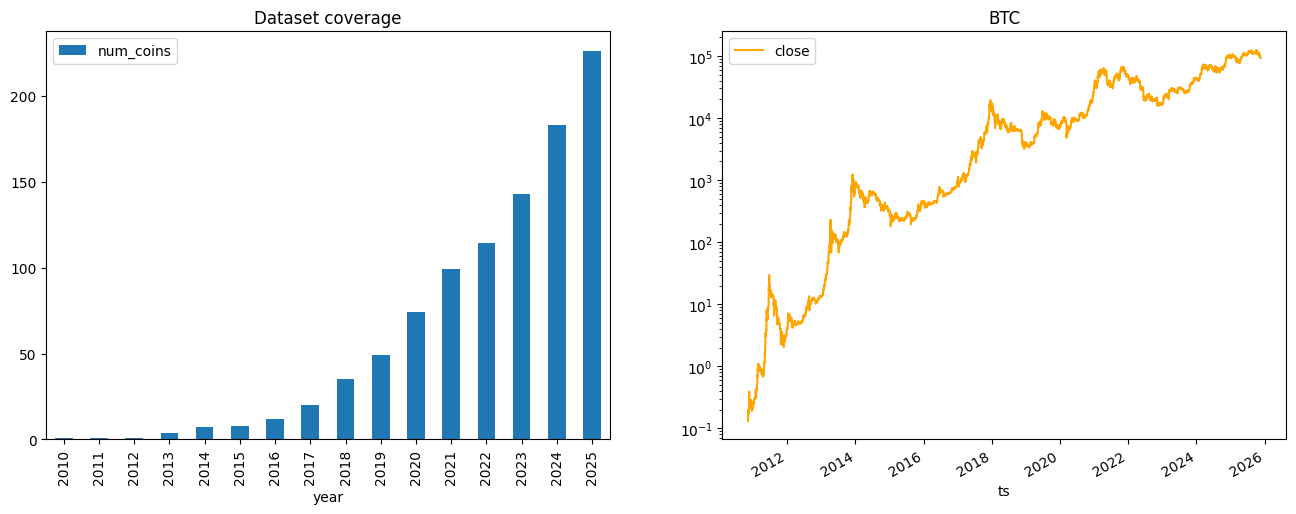

In [2]:
# coin data coverage

import matplotlib.pyplot as plt

df1 = con.sql('''
    select 
        year(ts) as year,
        count(distinct symbol) as num_coins
    from coins
    group by year
    order by year
''').df()

df2 = con.sql('''
    select
        ts, close
    from coins
    where symbol = 'btc'
    order by ts
''').df()

fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(16, 6))

df1.plot(ax=ax1, x='year', y='num_coins', kind='bar', title='Dataset coverage')
df2.plot(ax=ax2, x='ts', y='close', logy=True, color='orange', title='BTC')

plt.show()

Correlation With Past Momentum
------------------------------

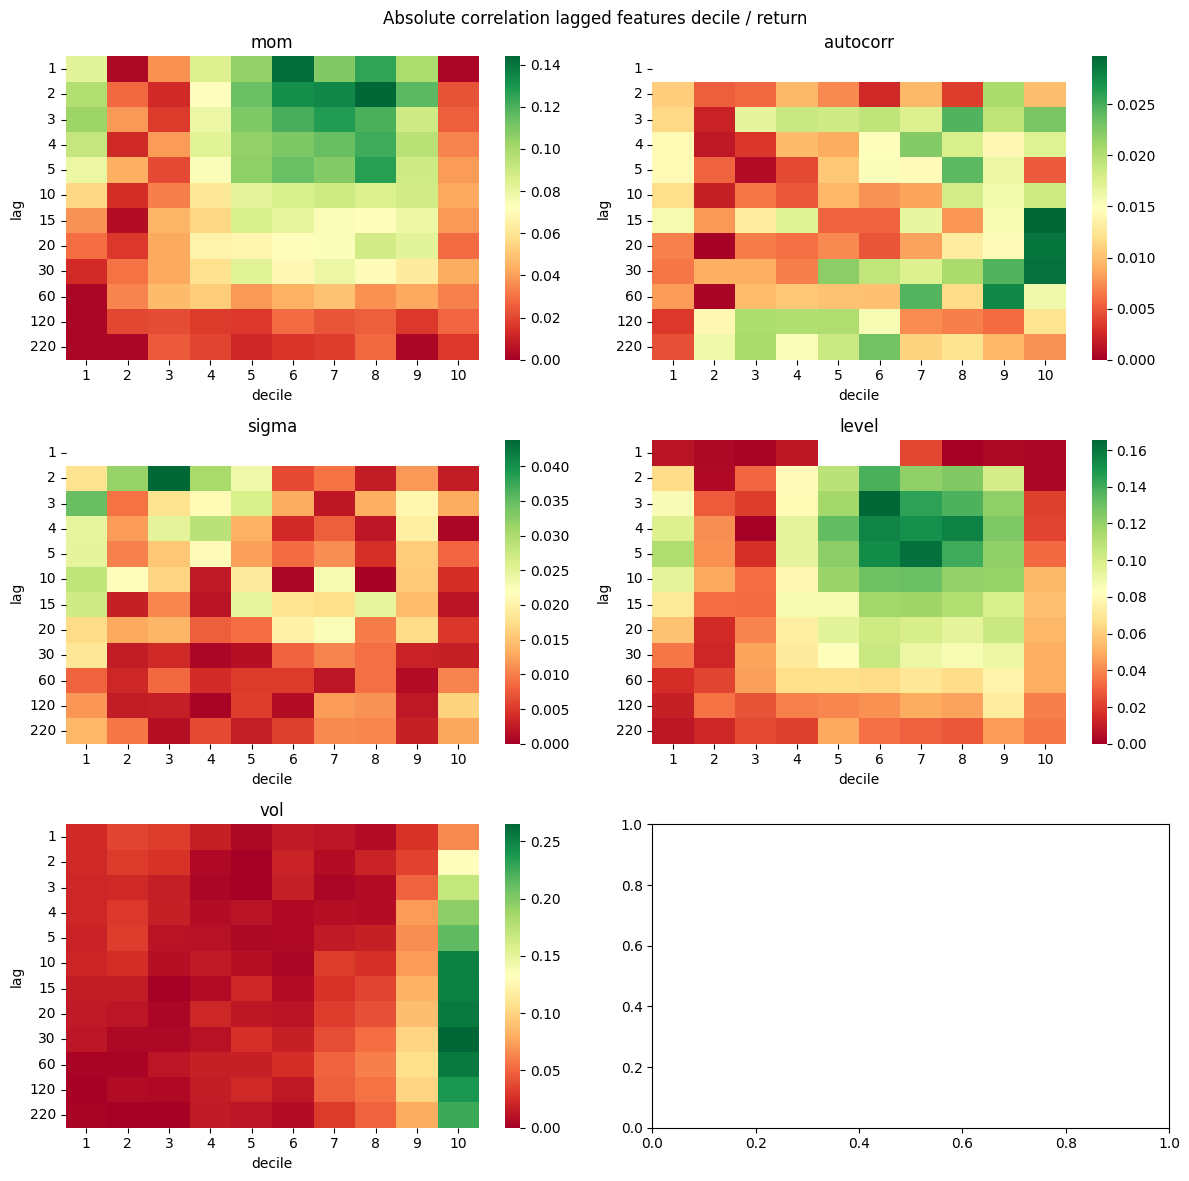

In [35]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

df = con.sql('''
    with narrow as (
        unpivot cs_features
        on mom, autocorr, sigma, level, vol
        into
            name feature value value
    ), deciles as (
        select
            lag, ret, feature, value,
            ntile(10) over (partition by ts, lag, feature order by value asc) as decile
        from narrow
    ), corr as (
        select lag, feature, decile, corr(ret, value) as corr
        from deciles
        where value is not null and isfinite(value)
        group by lag, decile, feature
    )
    pivot corr
    on feature
    using any_value(corr)
''').df()

fig, axes = plt.subplots(3, 2, figsize=(12, 12))
axes = axes.flatten()

for ax, feat in zip(axes, ['mom','autocorr','sigma','level','vol']):
    sns.heatmap(
        np.abs(df.pivot(index='lag', columns='decile', values=feat)),
        cmap='RdYlGn',vmin=0,ax=ax)
    ax.set_title(feat)


plt.suptitle('Absolute correlation lagged features decile / return')
plt.tight_layout()
plt.show()

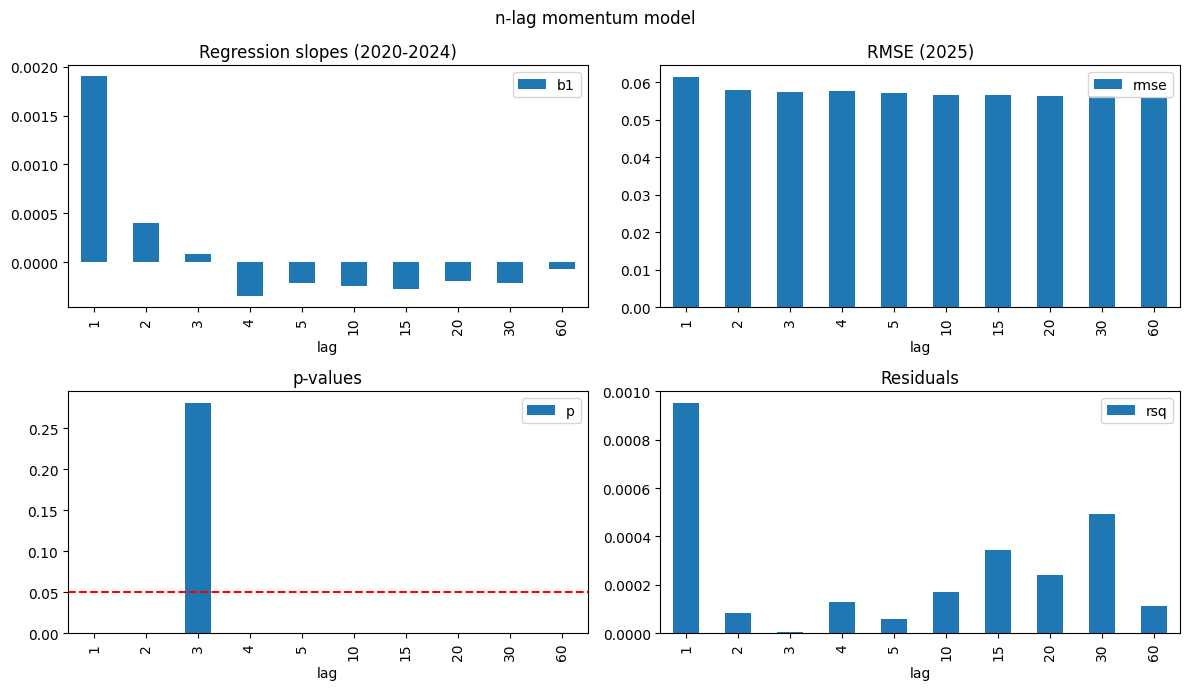

In [12]:
from scipy import stats

df = con.sql('''
    with model as (
        select
            lag, 
            regr_slope(ret, z) as b1,
            regr_intercept(ret, z) as b0,
            regr_r2(ret, z) as rsq,
            regr_count(ret, z) as n,
            corr(ret, z) as corr,
            (corr * sqrt(n - 2)) / sqrt(1 - power(corr, 2)) as t
        from momentum
        where year(ts) >= 2020 and year(ts) <= 2024
        group by lag
    )
    select
        m.lag,
        l.b1, l.rsq, l.n, l.corr, l.t,
        sqrt(avg(power(m.ret - (l.b1 * m.z + l.b0), 2))) as rmse
    from momentum m
    join model l on l.lag = m.lag
    where year(m.ts) = 2025
    group by m.lag, l.b1, l.rsq, l.n, l.corr, l.t,
    order by m.lag
''').df()


df['p'] = df.apply(lambda r: stats.t.sf(abs(r.t), r.n - 2) * 2, axis=1)

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12,7))

df.plot(x='lag',y='b1', kind='bar', ax=axes[0,0],title='Regression slopes (2020-2024)')
df.plot(x='lag',y='rmse', kind='bar', ax=axes[0,1],title='RMSE (2025)')
df.plot(x='lag',y='p', kind='bar', ax=axes[1,0],title='p-values')
axes[1,0].axhline(y=0.05, color='red', linestyle='dashed')
df.plot(x='lag',y='rsq',kind='bar',title='Residuals', ax=axes[1,1])

plt.suptitle('n-lag momentum model')
plt.tight_layout()
plt.show()

In [ ]:
df_yr = con.sql('''
    select
        year(ts) as year,
        lag,
        corr(mom, ret) as correlation
    from momentum
    where lag in (1,2,3,4,5,10,15,20,30,60)
    group by 1, 2
    order by 1, 2
''').df().pivot(index='year', columns='lag', values='correlation')

df_mo = con.sql('''
    select
        strftime(ts, '%Y-%m') as year_month,
        lag,
        abs(corr(mom, ret)) as correlation
    from momentum
    where lag in (1,2,3,4,5,10,15,20,30,60)
    group by 1, 2
    order by 1, 2
''').df().pivot(index='lag', columns='year_month', values='correlation')

df_ret = con.sql('''
    select
        m.ts,
        sum(v.rel_td * m.ret) / sum(v.rel_td) as ret
    from momentum m
    join volume v 
      on v.ts = m.ts and v.symbol = m.symbol
    where m.lag = 1
    group by m.ts
    order by m.ts
''').df()
df_ret['sma'] = df_ret.ret.rolling(window=200).mean()

fig, [ax1, ax2, ax3] = plt.subplots(3, 1, figsize=(10, 10), gridspec_kw={'height_ratios': [2, 1, .7]},layout='constrained')

df_yr.plot(
    ax=ax1,
    kind='bar',
    title='Correlation Daily Return and n-Day Momentum',
    colormap='viridis')
ax1.set_xlabel('')
ax1.legend(
    loc='upper center',
    bbox_to_anchor=(0.5, 1),
    ncol=10,
    frameon=False
)
ax1.tick_params(axis='x', rotation=45)

df_ret.mask(df_ret.sma <= 0).plot(ax=ax2, x='ts', y='sma', color='green', legend=False)
df_ret.mask(df_ret.sma > 0).plot(ax=ax2, x='ts', y='sma', color='red', legend=False)
ax2.axhline(y=0, color='black', linestyle='--', linewidth=1, alpha=0.5)

ax2.set_title('Daily Market Return (200 day SMA)')
ax2.set_ylabel('')
ax2.set_xlabel('')
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax2.xaxis.set_major_locator(mdates.YearLocator())
ax2.set_xlim(pd.Timestamp('2009-06-01'), pd.Timestamp('2025-06-01'))

sns.heatmap(
    df_mo,
    ax=ax3,
    annot=False,
    cmap='RdBu',
    center=0,
    cbar=False)
ax3.set_title('Correlation Strength')
ax3.set_ylabel('Lookback Period (days)')
ax3.set_xlabel('')
ax3.tick_params(axis='x', rotation=45)

plt.show()

In [ ]:
# vol weight allocation
# add vol z score
# add mcap
# add auto correlation
# encode crossing as triangle wave 0.01 0.1 1 (bullish cross) 0.1 0.01 and negative on bearish
# try linear models
# different up down patterns (up up down) for example 
# sma/ema slope
# above ma and rising, vol above 20 sma and rising
 
duckdb.sql('''
create or replace table returns as
select
    year(ts) as year,
    symbol,
    lag,
    sum(ret) as ret
from momentum
where mom > 0
group by year, symbol, lag
''')

duckdb.sql('''
create or replace table cross_alpha as
select
    r.year,
    r.lag,
    avg(r.ret - b.ret) as ret
from returns r
join benchmark b
  on b.year = r.year
group by r.year, r.lag
''')